# OBSERVABLES

In [2]:
from pygor3 import *
import numpy as np

In [3]:
mdl = IgorModel.load_default("human", "tcr_beta")

modelpath :  /home/olivares/.local/share/igor/models
modelpath :  /home/olivares/.local/share/igor/models
Parms filename:  /home/olivares/.local/share/igor/models/human/tcr_beta/models/model_parms.txt
Marginals filename:  /home/olivares/.local/share/igor/models/human/tcr_beta/models/model_marginals.txt
modelpath :  /home/olivares/.local/share/igor/models


In [4]:
fln_scenarios = "delete_me/ttmmpp_output/best_scenarios_counts.csv"
df_scenarios = mdl.get_dataframe_scenarios(fln_scenarios)
df_scenarios.head()

igor_fln_generated_realizations_werr:  delete_me/ttmmpp_output/best_scenarios_counts.csv


,scenario_rank,scenario_proba_cond_seq,v_choice,j_choice,d_gene,v_3_del,d_5_del,j_5_del,d_3_del,vd_ins,vd_dinucl,dj_ins,dj_dinucl,Mismatches,norm_scenario_proba_cond_seq
seq_index,,,,,,,,,,,,,,,
998,1,0.783497,77,4,0,9,6,19,9,4,"[1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000801
998,2,0.076884,77,4,0,9,6,19,10,4,"[1, 1, 2, 3]",8,"[2, 2, 2, 2, 0, 2, 0, 2]",[],0.000079
998,3,0.043634,77,4,0,9,7,19,9,5,"[1, 1, 2, 3, 2]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000045
998,4,0.023517,77,4,0,10,6,19,9,5,"[1, 1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000024
998,5,0.021809,77,4,0,9,8,19,9,6,"[1, 1, 2, 3, 2, 0]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000022


## CDR3 as an observable

In [5]:
def observable_get_CDR3(ps_scenario):
    """
    Return the numbers of amino acids in vd insertions
    """
    try:
        v_choice = mdl.realization(ps_scenario, 'v_choice')
        j_choice = mdl.realization(ps_scenario, 'j_choice')
        d_gene = mdl.realization(ps_scenario, 'd_gene')

        v_3_del = mdl.realization(ps_scenario, 'v_3_del')
        d_5_del = mdl.realization(ps_scenario, 'd_5_del')
        d_3_del = mdl.realization(ps_scenario, 'd_3_del')
        j_5_del = mdl.realization(ps_scenario, 'j_5_del')

        # vd_ins = mdl.realization(ps_scenario, 'vd_ins')
        vd_dinucl = mdl.realization(ps_scenario, 'vd_dinucl')

        # dj_ins = mdl.realization(ps_scenario, 'dj_ins')
        dj_dinucl = mdl.realization(ps_scenario, 'dj_dinucl')

        v_anchor = mdl.V_anchor(v_choice.id)
        j_anchor = mdl.J_anchor(j_choice.id)

        # TODO: mdl.get_CDR3_seq(ps_scenario)
        ##### V_Gene
        v_gene_len = len(v_choice.value)
        # mdl.get_CDR3_seq(ps_scenario)
        v_ini = 0
        v_end = v_gene_len
        str_v_3_palidrome = ""
        if v_3_del.value < 0:
            str_v_3_palidrome = dna_complementary((v_choice.value[v_3_del.value:])[::-1])
        else:
            v_end = v_end - v_3_del.value

        str_V_segment = v_choice.value[v_ini:v_end] + str_v_3_palidrome

        ##### D_gene
        d_gene_len = len(d_gene.value)
        d_ini = 0
        d_end = d_gene_len
        str_d_5_palidrome = ""
        if d_5_del.value < 0:
            int_ini = 0
            str_d_5_palidrome = dna_complementary((d_gene.value[:-d_5_del.value])[::-1])
        else:
            d_ini = d_5_del.value

        str_d_3_palidrome = ""
        if d_3_del.value < 0:
            str_d_3_palidrome = dna_complementary((d_gene.value[d_3_del.value:])[::-1])
        else:
            d_end = d_end - d_3_del.value

        str_D_segment = str_d_5_palidrome + d_gene.value[d_ini:d_end] + str_d_3_palidrome

        ##### J_gene
        j_gene_len = len(j_choice.value)
        j_ini = 0
        j_end = j_gene_len
        str_j_5_palindrome = ""
        if j_5_del.value < 0:
            j_ini = 0
            str_j_5_palindrome = dna_complementary((j_choice.value[:-j_5_del.value])[::-1])
        else:
            j_ini = j_5_del.value

        str_J_segment = str_j_5_palindrome + j_choice.value[j_ini:j_end]

        str_VD_segment = "".join(vd_dinucl.value)
        str_DJ_segment = "".join(dj_dinucl.value[::-1])

        if (v_anchor > v_end) or (j_anchor < j_ini):
            return np.NaN
        else:
            str_sequence = str_V_segment[v_anchor:] + str_VD_segment + str_D_segment + str_DJ_segment + str_J_segment[:j_anchor]
            # return dna_translate(str_sequence)
            if len(str_sequence) % 3 == 0:
                return dna_translate(str_sequence)
            else:
                return 'NoProductive'
    except Exception as e:
        # print(e) # FIXME: A 0 is returned as Exception
        return None # FIXME: what to do in these cases, this will change the normalization.


### get_observable_from_scenarios_dataframe

In [7]:
%%time
df_scenarios['CDR3'] = mdl.get_observable_from_df_scenarios(observable_get_CDR3, df_scenarios)
df_scenarios.head()

CPU times: user 8.52 s, sys: 0 ns, total: 8.52 s
Wall time: 8.5 s


,scenario_rank,scenario_proba_cond_seq,v_choice,j_choice,d_gene,v_3_del,d_5_del,j_5_del,d_3_del,vd_ins,vd_dinucl,dj_ins,dj_dinucl,Mismatches,norm_scenario_proba_cond_seq,CDR3
seq_index,,,,,,,,,,,,,,,,
998,1,0.783497,77,4,0,9,6,19,9,4,"[1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000801,None
998,2,0.076884,77,4,0,9,6,19,10,4,"[1, 1, 2, 3]",8,"[2, 2, 2, 2, 0, 2, 0, 2]",[],0.000079,None
998,3,0.043634,77,4,0,9,7,19,9,5,"[1, 1, 2, 3, 2]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000045,None
998,4,0.023517,77,4,0,10,6,19,9,5,"[1, 1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000024,None
998,5,0.021809,77,4,0,9,8,19,9,6,"[1, 1, 2, 3, 2, 0]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000022,None


In [6]:
df_scenarios['CDR3']

seq_index
998          NoProductive
998          NoProductive
998          NoProductive
998          NoProductive
998          NoProductive
              ...        
703    CASSQGIAGPRGPTS*LS
703          NoProductive
703    CASSQGIAGPRGPTS*LS
703    CASSQGIAGPRGPTS*LS
703    CASSQGIAGPRGPTS*LS
Name: CDR3, Length: 10000, dtype: object

In [4]:
da_P = mdl.get_P_from_scenarios_cols(df_scenarios, ['v_choice', 'CDR3'])
da_P.mean()

KeyError: 'CDR3'

In [8]:
da_P.sum()

<xarray.DataArray 'norm_scenario_proba_cond_seq' ()>
array(0.997)

In [9]:
da_P.sel({'v_choice':40, 'CDR3': 'CASRDRGAVFW'})

<xarray.DataArray 'norm_scenario_proba_cond_seq' ()>
array(0.00071446)
Coordinates:
    v_choice  int64 40
    CDR3      <U11 'CASRDRGAVFW'

In [10]:
da_P_CDR3 = mdl.get_P_from_scenarios_cols(df_scenarios, ['CDR3'])
da_P_CDR3

<xarray.DataArray 'norm_scenario_proba_cond_seq' (CDR3: 737)>
array([2.10871258e-04, 1.06907257e-04, 9.55472497e-05, 3.91025721e-05,
       8.89871842e-04, 2.22909579e-05, 6.09749693e-04, 5.54054093e-05,
       9.14677052e-04, 2.23230292e-04, 9.78506279e-04, 8.22960606e-04,
       9.03969818e-04, 1.54448512e-04, 1.18388232e-05, 1.31500675e-04,
       8.32939598e-05, 2.37699016e-05, 6.38606184e-04, 8.33707254e-04,
       1.50292923e-04, 6.64391812e-04, 1.42471008e-05, 3.35267198e-04,
       1.00000000e-03, 1.00000000e-03, 9.39886951e-04, 3.12125089e-04,
       1.03673134e-04, 9.67609144e-05, 1.49478719e-04, 2.73049682e-04,
       1.36462444e-04, 5.06234809e-05, 8.39266251e-04, 1.71292629e-05,
       6.56874975e-05, 7.43080789e-04, 9.46457348e-04, 1.22023857e-04,
       3.02091141e-05, 8.03745567e-04, 1.55673795e-04, 6.21671048e-04,
       9.24611426e-04, 9.04549092e-04, 7.35960961e-04, 1.93450694e-05,
       1.74043188e-04, 8.68109499e-05, 2.59395492e-04, 7.84799552e-04,
       8.57903826e-04, 6.16969180e-05, 8.31436114e-04, 6.74039495e-04,
       7.86102683e-05, 9.52476818e-04, 6.30824734e-05, 2.87145587e-05,
       9.12770152e-04, 1.19815579e-04, 8.25124125e-04, 2.18862212e-04,
       1.00000000e-03, 3.45825009e-05, 8.35443098e-04, 2.05482388e-04,
       8.32356507e-05, 7.81960904e-04, 9.05602720e-04, 5.48837714e-05,
       2.07558165e-04, 3.62878735e-04, 1.44393543e-04, 8.49762106e-04,
       3.95975663e-05, 1.53082086e-04, 5.40217813e-04, 1.00000000e-03,
...
       4.54346764e-05, 8.37541605e-04, 1.37023751e-04, 9.50588421e-04,
       9.63374230e-04, 9.37827649e-04, 5.05595759e-05, 1.00000000e-03,
       1.03274902e-04, 1.00000000e-03, 4.60282604e-05, 1.00000000e-03,
       5.84314593e-05, 9.03177742e-04, 2.54081848e-04, 4.30344846e-05,
       4.15048257e-05, 8.26204987e-05, 3.09170545e-04, 4.46334578e-05,
       9.12390214e-04, 8.21726317e-04, 9.78950684e-04, 7.88778246e-05,
       1.00000000e-03, 2.07620085e-04, 1.43617457e-05, 4.40827186e-04,
       8.15381574e-04, 1.36736141e-04, 7.59579626e-04, 9.63825272e-04,
       7.70389574e-05, 1.00000000e-03, 1.00000000e-03, 9.59706894e-04,
       5.93322228e-05, 7.28820208e-04, 2.10452125e-04, 9.03108613e-04,
       2.71668779e-04, 1.00000000e-03, 6.02243131e-05, 9.77637119e-04,
       9.80394692e-05, 3.91646108e-04, 1.46166436e-05, 1.99396506e-04,
       2.36737769e-04, 7.89869079e-04, 1.64775362e-04, 2.05338159e-04,
       9.71326695e-05, 1.85190465e-05, 9.49665838e-04, 2.63136686e-05,
       1.00000000e-03, 1.39014597e-04, 7.09158505e-05, 8.98550082e-05,
       1.00000000e-03, 3.85417178e-05, 6.50207864e-04, 7.48508872e-04,
       3.84602160e-05, 8.05334469e-04, 1.42996910e-05, 4.14589287e-04,
       1.57012919e-04, 9.24472859e-04, 6.16238983e-04, 3.93178346e-05,
       9.25018108e-04, 1.66823300e-04, 5.93516292e-04, 9.12304394e-04,
       6.66447640e-01])
Coordinates:
  * CDR3     (CDR3) object 'CACIVTRRDKNCFLAV' 'CADRRQGEH*SFL' ... 'NoProductive'

<AxesSubplot:xlabel='CDR3'>

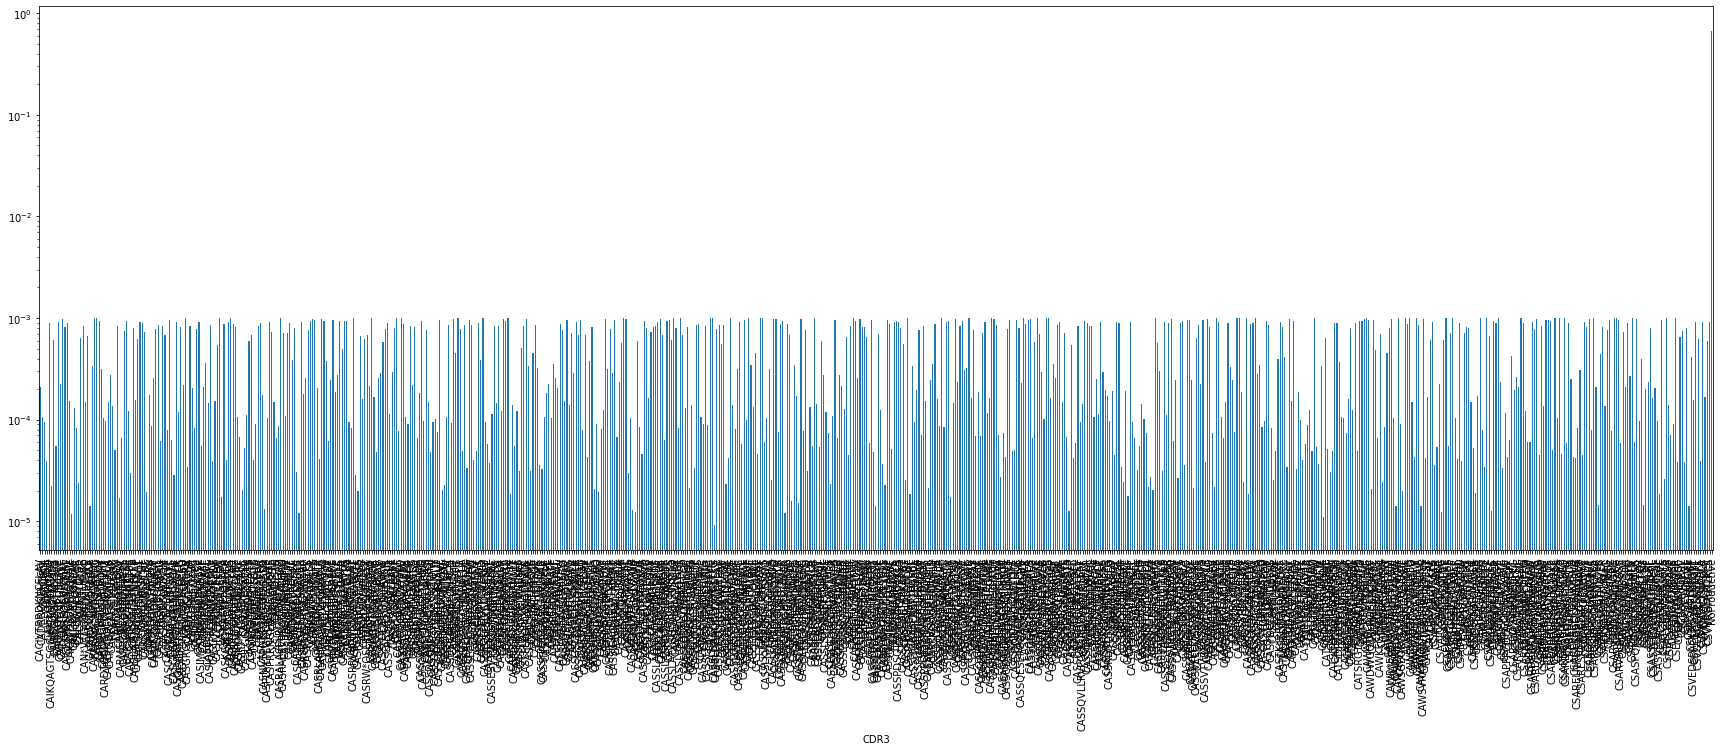

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,10))
ax.set_yscale('log')
df_P_CDR3 = da_P_CDR3.to_pandas()
# zeros_p
df_P_CDR3.plot.bar(ax=ax)

In [12]:
### DEFAULT CDR3

In [13]:
df_scenarios['CDR3_py'] = mdl.get_VDJ_CDR3_from_df_scenario(df_scenarios)
df_scenarios.head()

,scenario_rank,scenario_proba_cond_seq,v_choice,j_choice,d_gene,v_3_del,d_5_del,j_5_del,d_3_del,vd_ins,vd_dinucl,dj_ins,dj_dinucl,Mismatches,norm_scenario_proba_cond_seq,CDR3,CDR3_py
seq_index,,,,,,,,,,,,,,,,,
998,1,0.783497,77,4,0,9,6,19,9,4,"[1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000801,NoProductive,NaN
998,2,0.076884,77,4,0,9,6,19,10,4,"[1, 1, 2, 3]",8,"[2, 2, 2, 2, 0, 2, 0, 2]",[],0.000079,NoProductive,NaN
998,3,0.043634,77,4,0,9,7,19,9,5,"[1, 1, 2, 3, 2]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000045,NoProductive,NaN
998,4,0.023517,77,4,0,10,6,19,9,5,"[1, 1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000024,NoProductive,NaN
998,5,0.021809,77,4,0,9,8,19,9,6,"[1, 1, 2, 3, 2, 0]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000022,NoProductive,NaN


### other example

In [37]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
hydro_aa_list = ['M', 'L', 'I', 'V']
def observable_n_hydro(ps_scenario):
    seq_aa_CDR3 = observable_get_CDR3(ps_scenario)
    if (seq_aa_CDR3 is None) or (seq_aa_CDR3 is np.NaN):
        return np.NaN
    else:
        analyzed_seq = ProteinAnalysis(str(seq_aa_CDR3))
        aa_counts_dict = analyzed_seq.count_amino_acids()    
        aa_counts = 0
        for aa in hydro_aa_list:
            aa_counts = aa_counts + aa_counts_dict[aa]
        return aa_counts

In [38]:
%%time
df_scenarios['n_hydro'] = mdl.get_observable_from_scenarios_dataframe(observable_n_hydro, df_scenarios)
df_scenarios.head()

,scenario_rank,scenario_proba_cond_seq,v_choice,j_choice,d_gene,v_3_del,d_5_del,j_5_del,d_3_del,vd_ins,vd_dinucl,dj_ins,dj_dinucl,Mismatches,norm_scenario_proba_cond_seq,CDR3,CDR3_py,n_hydro
seq_index,,,,,,,,,,,,,,,,,,
998,1,0.783497,77,4,0,9,6,19,9,4,"[1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000801,NoProductive,NaN,0.0
998,2,0.076884,77,4,0,9,6,19,10,4,"[1, 1, 2, 3]",8,"[2, 2, 2, 2, 0, 2, 0, 2]",[],0.000079,NoProductive,NaN,0.0
998,3,0.043634,77,4,0,9,7,19,9,5,"[1, 1, 2, 3, 2]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000045,NoProductive,NaN,0.0
998,4,0.023517,77,4,0,10,6,19,9,5,"[1, 1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000024,NoProductive,NaN,0.0
998,5,0.021809,77,4,0,9,8,19,9,6,"[1, 1, 2, 3, 2, 0]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000022,NoProductive,NaN,0.0


In [39]:
da_n_hydro = mdl.get_P_from_scenarios_cols(df_scenarios, ['n_hydro'])
da_n_hydro

<xarray.DataArray 'norm_scenario_proba_cond_seq' (n_hydro: 7)>
array([0.70461721, 0.07812675, 0.09171433, 0.07252926, 0.03611753,
       0.00983321, 0.00406171])
Coordinates:
  * n_hydro  (n_hydro) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0

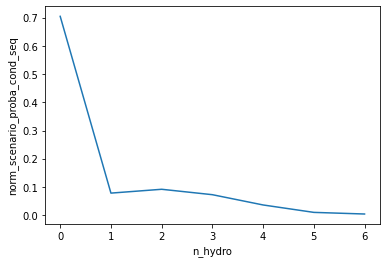

In [41]:
da_n_hydro.plot()

In [43]:
da_n_hydro.sum()

<xarray.DataArray 'norm_scenario_proba_cond_seq' ()>
array(0.997)

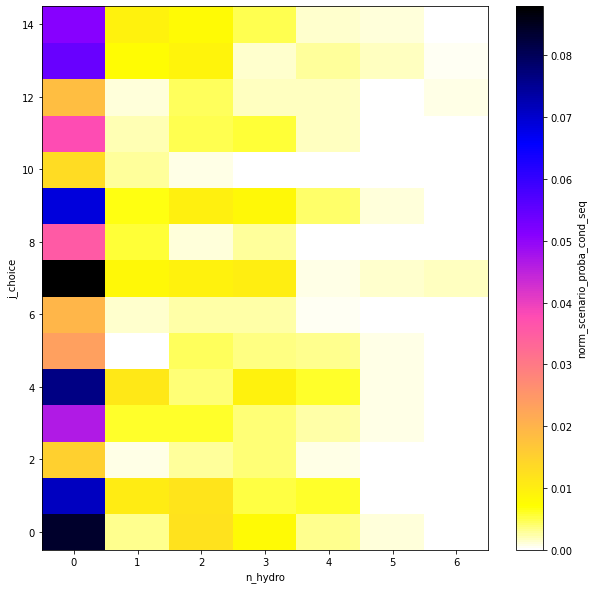

In [52]:
da_gene_n_hydro = mdl.get_P_from_scenarios_cols(df_scenarios, ['j_choice', 'n_hydro'])
fig, ax = plt.subplots(figsize=(10,10))
da_gene_n_hydro.plot(ax=ax, cmap='gnuplot2_r')

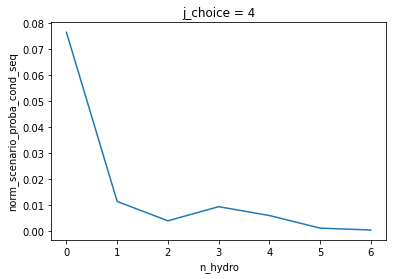

In [53]:
da_gene_n_hydro.sel({'j_choice': 4}).plot()

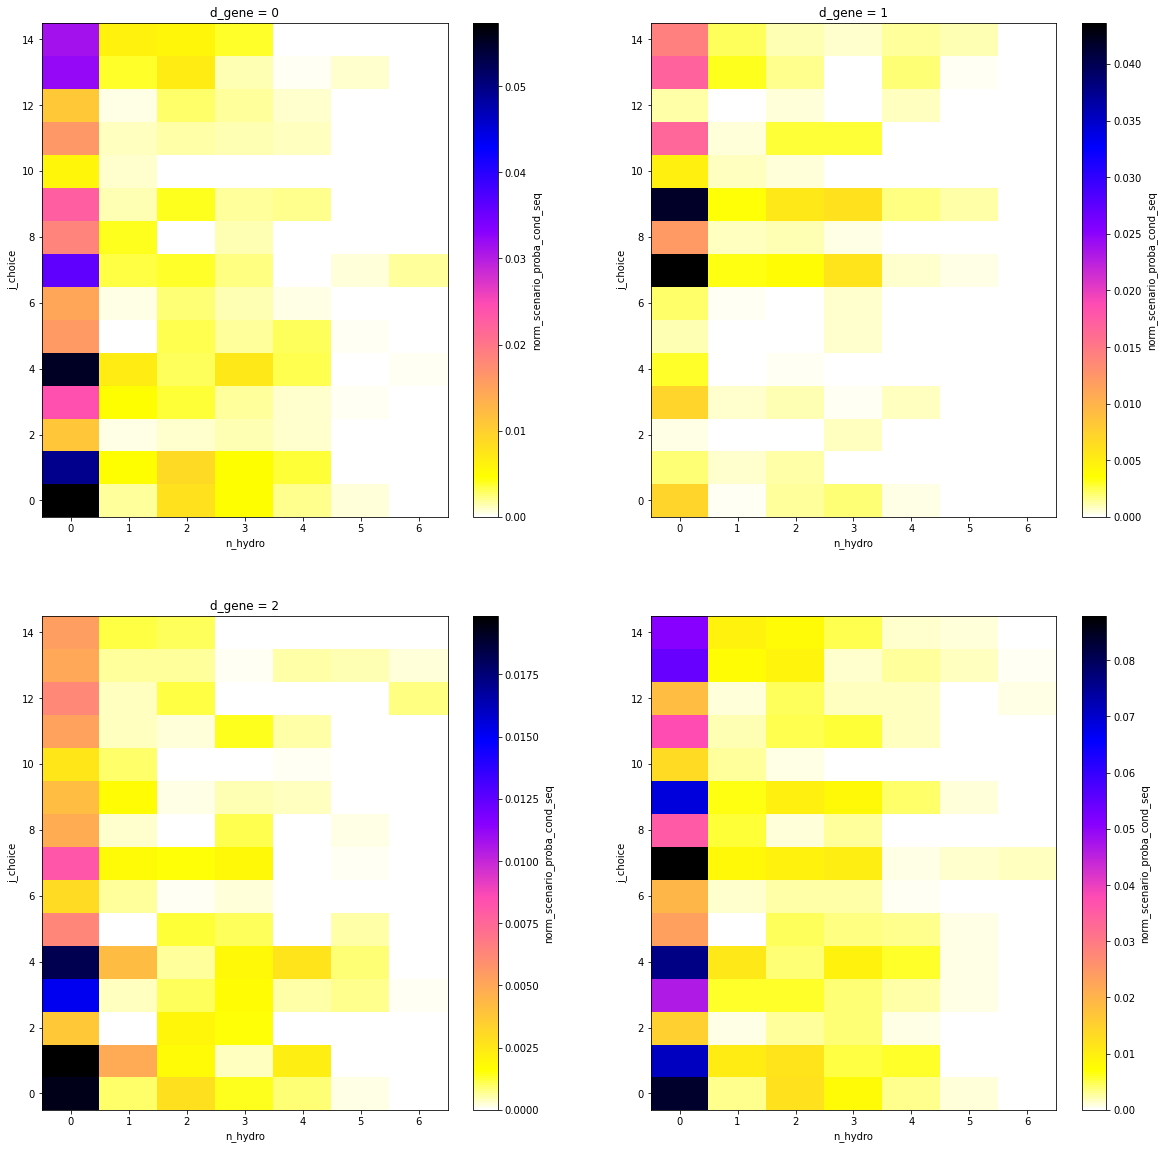

In [60]:
da_2genes_n_hydro = mdl.get_P_from_scenarios_cols(df_scenarios, ['j_choice', 'd_gene', 'n_hydro'])
fig, ax = plt.subplots(2,2, figsize=(20,20))
da_2genes_n_hydro.sel({'d_gene': 0 }).plot(ax=ax[0][0], cmap='gnuplot2_r')
da_2genes_n_hydro.sel({'d_gene': 1 }).plot(ax=ax[0][1], cmap='gnuplot2_r')
da_2genes_n_hydro.sel({'d_gene': 2 }).plot(ax=ax[1][0], cmap='gnuplot2_r')
da_2genes_n_hydro.sum(dim='d_gene').plot(ax=ax[1][1], cmap='gnuplot2_r')

In [14]:
def observable_correlation(ps_scenario):
    vd_ins = mdl.realization(ps_scenario, 'vd_ins')
    dj_ins = mdl.realization(ps_scenario, 'dj_ins')
    return vd_ins.value*dj_ins.value

In [15]:
df_scenarios['ins_corr'] = mdl.get_observable_from_scenarios_dataframe(observable_correlation, df_scenarios)
df_scenarios.head()

,scenario_rank,scenario_proba_cond_seq,v_choice,j_choice,d_gene,v_3_del,d_5_del,j_5_del,d_3_del,vd_ins,vd_dinucl,dj_ins,dj_dinucl,Mismatches,norm_scenario_proba_cond_seq,CDR3,ins_corr
seq_index,,,,,,,,,,,,,,,,,
998,1,0.783497,77,4,0,9,6,19,9,4,"[1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000801,NoProductive,28
998,2,0.076884,77,4,0,9,6,19,10,4,"[1, 1, 2, 3]",8,"[2, 2, 2, 2, 0, 2, 0, 2]",[],0.000079,NoProductive,32
998,3,0.043634,77,4,0,9,7,19,9,5,"[1, 1, 2, 3, 2]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000045,NoProductive,35
998,4,0.023517,77,4,0,10,6,19,9,5,"[1, 1, 1, 2, 3]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000024,NoProductive,35
998,5,0.021809,77,4,0,9,8,19,9,6,"[1, 1, 2, 3, 2, 0]",7,"[2, 2, 2, 2, 0, 2, 0]",[],0.000022,NoProductive,42


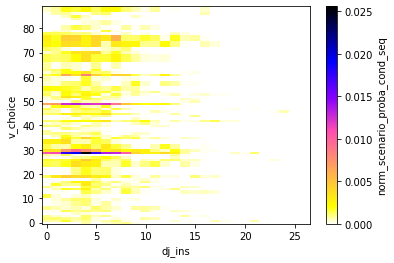

In [21]:
da = mdl.get_P_from_scenarios_cols(df_scenarios, ['v_choice', 'dj_ins','ins_corr'])
da.sum('ins_corr').plot(cmap='gnuplot2_r')

In [39]:
aaa = df_scenarios.groupby('ins_corr')['norm_scenario_proba_cond_seq'].sum()
aaa

ins_corr
0      0.126748
1      0.003528
2      0.015140
3      0.016946
4      0.032758
         ...   
224    0.000097
228    0.000206
231    0.000062
234    0.000157
238    0.000126
Name: norm_scenario_proba_cond_seq, Length: 133, dtype: float64

In [40]:
type(aaa)

pandas.core.series.Series

In [33]:
(df_scenarios['ins_corr']*df_scenarios['norm_scenario_proba_cond_seq']).sum()

25.985685213409095

In [41]:
average = (mdl.get_observable_from_scenarios_dataframe(observable_correlation, df_scenarios)*df_scenarios['norm_scenario_proba_cond_seq'] ).sum()
average

25.985685213409095

In [176]:
v_choice = mdl.realization(df_scenarios, 'v_choice')

In [57]:
v_choice.id

seq_index
998    77
998    77
998    77
998    77
998    77
       ..
703    45
703    45
703    45
703    45
703    45
Name: v_choice, Length: 10000, dtype: int64

In [49]:
v_choice.value

array(['GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGGGACGGGATGTAGCTCTCAGGTGTGATTCAATTTCGGGTCATGTAACCCTTTATTGGTACCGACAGACCCTGGGGCAGGGCTCAGAGGTTCTGACTTACTCCCAGAGTGATGCTCAACGAGACAAATCAGGGCGGCCCAGTGGTCGGTTCTCTGCAGAGAGGCCTGAGAGATCCGTCTCCACTCTGAAGATCCAGCGCACAGAGCAGGGGGACTCAGCTGTGTATCTCTGTGCCAGCAGCTTAGC',
       'GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGGGACGGGATGTAGCTCTCAGGTGTGATTCAATTTCGGGTCATGTAACCCTTTATTGGTACCGACAGACCCTGGGGCAGGGCTCAGAGGTTCTGACTTACTCCCAGAGTGATGCTCAACGAGACAAATCAGGGCGGCCCAGTGGTCGGTTCTCTGCAGAGAGGCCTGAGAGATCCGTCTCCACTCTGAAGATCCAGCGCACAGAGCAGGGGGACTCAGCTGTGTATCTCTGTGCCAGCAGCTTAGC',
       'GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGGGACGGGATGTAGCTCTCAGGTGTGATTCAATTTCGGGTCATGTAACCCTTTATTGGTACCGACAGACCCTGGGGCAGGGCTCAGAGGTTCTGACTTACTCCCAGAGTGATGCTCAACGAGACAAATCAGGGCGGCCCAGTGGTCGGTTCTCTGCAGAGAGGCCTGAGAGATCCGTCTCCACTCTGAAGATCCAGCGCACAGAGCAGGGGGACTCAGCTGTGTATCTCTGTGCCAGCAGCTTAGC',
       ...,
       'ACTGAAGTTACCCAGACACCAAAACACCTGGTCATGGGAATGACAAATAAGAAGTCTTTGAAATGTGAACAACATAT

In [50]:
v_choice.name

array(['L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|270051..270340|290 nt|1| | | | |290+0=290| | |',
       'L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|270051..270340|290 nt|1| | | | |290+0=290| | |',
       'L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|270051..270340|290 nt|1| | | | |290+0=290| | |',
       ...,
       "U07977|TRBV4-1*01|Homo sapiens|F|V-REGION|10271..10554|284 nt|1| | | | |284+0=284|partial in 5' and 3'| |",
       "U07977|TRBV4-1*01|Homo sapiens|F|V-REGION|10271..10554|284 nt|1| | | | |284+0=284|partial in 5' and 3'| |",
       "U07977|TRBV4-1*01|Homo sapiens|F|V-REGION|10271..10554|284 nt|1| | | | |284+0=284|partial in 5' and 3'| |"],
      dtype=object)

In [51]:
v_choice_ah = mdl.realization(df_scenarios.iloc[0], 'v_choice')

In [53]:
v_choice_ah.id

77

In [54]:
v_choice_ah.value

'GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGGGACGGGATGTAGCTCTCAGGTGTGATTCAATTTCGGGTCATGTAACCCTTTATTGGTACCGACAGACCCTGGGGCAGGGCTCAGAGGTTCTGACTTACTCCCAGAGTGATGCTCAACGAGACAAATCAGGGCGGCCCAGTGGTCGGTTCTCTGCAGAGAGGCCTGAGAGATCCGTCTCCACTCTGAAGATCCAGCGCACAGAGCAGGGGGACTCAGCTGTGTATCTCTGTGCCAGCAGCTTAGC'

In [55]:
v_choice_ah.name

'L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|270051..270340|290 nt|1| | | | |290+0=290| | |'

In [59]:
vd_dinucl = mdl.realization(df_scenarios.iloc[0], 'vd_dinucl')

In [60]:
vd_dinucl.id

[1, 1, 2, 3]

In [61]:
vd_dinucl.value

array(['C', 'C', 'G', 'T'], dtype=object)

In [62]:
vd_dinucl.name

array(['', '', '', ''], dtype=object)

In [64]:
vd_dinucl = mdl.realization(df_scenarios.iloc[0], 'vd_dinucl')

In [65]:
vd_dinucl.id

[1, 1, 2, 3]

In [66]:
vd_dinucl.value

array(['C', 'C', 'G', 'T'], dtype=object)

In [67]:
vd_dinucl.name

array(['', '', '', ''], dtype=object)

In [69]:
df_scenarios['vd_dinucl']

seq_index
998                [1, 1, 2, 3]
998                [1, 1, 2, 3]
998             [1, 1, 2, 3, 2]
998             [1, 1, 1, 2, 3]
998          [1, 1, 2, 3, 2, 0]
                 ...           
703          [2, 2, 1, 0, 3, 3]
703             [2, 1, 0, 3, 3]
703             [2, 1, 0, 3, 3]
703    [2, 2, 1, 0, 3, 3, 2, 1]
703    [2, 1, 0, 3, 3, 2, 1, 2]
Name: vd_dinucl, Length: 10000, dtype: object

In [77]:
ids = df_scenarios['vd_dinucl'].values
ids

array([list([1, 1, 2, 3]), list([1, 1, 2, 3]), list([1, 1, 2, 3, 2]), ...,
       list([2, 1, 0, 3, 3]), list([2, 2, 1, 0, 3, 3, 2, 1]),
       list([2, 1, 0, 3, 3, 2, 1, 2])], dtype=object)

In [74]:
df_scenarios['vd_dinucl']

seq_index
998                [1, 1, 2, 3]
998                [1, 1, 2, 3]
998             [1, 1, 2, 3, 2]
998             [1, 1, 1, 2, 3]
998          [1, 1, 2, 3, 2, 0]
                 ...           
703          [2, 2, 1, 0, 3, 3]
703             [2, 1, 0, 3, 3]
703             [2, 1, 0, 3, 3]
703    [2, 2, 1, 0, 3, 3, 2, 1]
703    [2, 1, 0, 3, 3, 2, 1, 2]
Name: vd_dinucl, Length: 10000, dtype: object

In [78]:
isinstance(df_scenarios['vd_dinucl'], pd.DataFrame)

False

In [159]:
### As a pandas series
def realiz_map(list_of_ids):
    pd_dataframe = mdl.parms.Event_dict[event_nickname].loc[list_of_ids]
    return pd_dataframe

def realiz_map_value(list_of_ids):
    pd_dataframe = mdl.parms.Event_dict[event_nickname].loc[list_of_ids]
    return pd_dataframe.value.values

def realiz_map_name(list_of_ids):
    pd_dataframe = mdl.parms.Event_dict[event_nickname].loc[list_of_ids]
    return pd_dataframe.name.values
v_realiz_map_value = np.vectorize(realiz_map_value)
v_realiz_map_name = np.vectorize(realiz_map_name)
v_realiz_map = np.vectorize(realiz_map)

In [160]:
# event_nickname = 'v_choice'
event_nickname = 'vd_dinucl'
id = df_scenarios[event_nickname]
if isinstance(id, pd.Series):
    if id.values.dtype == 'object':
        # So I need to put this as a map
        realiz = v_realiz_map(id.values)
    else:
        realiz = mdl.parms.Event_dict[event_nickname].loc[id.values]
# IT ACCEPTS NUMPY ARRAYS AS INDICES.
# realiz

In [272]:
realiz = mdl.realization(df_scenarios, 'v_choice')
# realiz

In [278]:

# realiz.id['value'] = realiz.value

/home/olivares/anaconda3/envs/pygor3-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [209]:
event_nickname = 'vd_dinucl'
id = df_scenarios[event_nickname]
id

seq_index
998                [1, 1, 2, 3]
998                [1, 1, 2, 3]
998             [1, 1, 2, 3, 2]
998             [1, 1, 1, 2, 3]
998          [1, 1, 2, 3, 2, 0]
                 ...           
703          [2, 2, 1, 0, 3, 3]
703             [2, 1, 0, 3, 3]
703             [2, 1, 0, 3, 3]
703    [2, 2, 1, 0, 3, 3, 2, 1]
703    [2, 1, 0, 3, 3, 2, 1, 2]
Name: vd_dinucl, Length: 10000, dtype: object

In [247]:
df_tmp = pd.DataFrame()
df_tmp['id'] = df_scenarios[event_nickname]
df_tmp['value'] = df_scenarios[event_nickname].apply(lambda x: mdl.parms.Event_dict[event_nickname].loc[x].value.values)
df_tmp['name'] = df_scenarios[event_nickname].apply(lambda x: mdl.parms.Event_dict[event_nickname].loc[x].name.values)

In [267]:
oop = df_tmp.to_records(index=False)
oop[0].value


'CCGT'

In [266]:
myfunc = lambda x: "".join(x.value)
myfunc(oop[0])


array(['C', 'C', 'G', 'T'], dtype=object)

In [264]:
v_myfunc = np.vectorize(myfunc)
v_myfunc(oop)

AttributeError: 'tuple' object has no attribute 'value'

In [ ]:
# FIXME: isinstance(id, pd.Series)
realiz = 
realiz.index.values
# realiz.value.values
# realiz.name.values

In [224]:
import pandas as pd
   
# Dataframe generation
gfg_string = 'geeksforgeeks'
gfg_list = 5 * [pd.Series(list(gfg_string))]
   
gfg_df = pd.DataFrame(data = gfg_list)
print("Original dataframe:\n" + \
      gfg_df.to_string(index = False,
      header = False), end = '\n\n')
   
# Using apply method for sorting 
# rows of characters present in 
# the original dataframe
new_gfg_df = gfg_df.apply(lambda x:x.sort_values(), axis = 1)
  
print("Transformed dataframe:\n" + \
       new_gfg_df.to_string(index = False,
            header = False), end = '\n\n')

Original dataframe:
g e e k s f o r g e e k s
g e e k s f o r g e e k s
g e e k s f o r g e e k s
g e e k s f o r g e e k s
g e e k s f o r g e e k s

Transformed dataframe:
e e e e f g g k k o r s s
e e e e f g g k k o r s s
e e e e f g g k k o r s s
e e e e f g g k k o r s s
e e e e f g g k k o r s s



In [226]:
gfg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,g,e,e,k,s,f,o,r,g,e,e,k,s
1,g,e,e,k,s,f,o,r,g,e,e,k,s
2,g,e,e,k,s,f,o,r,g,e,e,k,s
3,g,e,e,k,s,f,o,r,g,e,e,k,s
4,g,e,e,k,s,f,o,r,g,e,e,k,s


<class 'numpy.ndarray'>
unhashable type: 'list'


In [190]:
# I need to vectorize the function
# aaa = mdl.realization(df_scenarios, 'v_choice')
event_nickname = 'v_choice'
# event_nickname = 'vd_dinucl'
id = df_scenarios[event_nickname].values
print(id, type(id))
# FIXME: isinstance(id, pd.Series)
realiz = mdl.parms.Event_dict[event_nickname].loc[id]
realiz.index.values
# realiz.value.values
# realiz.name.values


[77 77 77 ... 45 45 45] <class 'numpy.ndarray'>


array([77, 77, 77, ..., 45, 45, 45])

[list([1, 1, 2, 3]) list([1, 1, 2, 3]) list([1, 1, 2, 3, 2]) ...
 list([2, 1, 0, 3, 3]) list([2, 2, 1, 0, 3, 3, 2, 1])
 list([2, 1, 0, 3, 3, 2, 1, 2])] <class 'numpy.ndarray'>


TypeError: unhashable type: 'list'

# Testando con dataframes

In [318]:
# input should be df_scenarios and event_nickname
event_nickname = 'v_choice'
df_scenarios[event_nickname]
id = df_scenarios[event_nickname]
print(type(id))
if id.dtype == 'object':
    print(True)
realiz = mdl.parms.Event_dict[event_nickname].loc[id.values]
final_df = pd.DataFrame(
    {
        'id' : id.values,
        'value' : realiz.value.values,
        'name' : realiz.name.values
    })

# id.values
# realiz.value

final_df.index = df_scenarios[event_nickname].index
# output
final_df.head()


<class 'pandas.core.series.Series'>


,id,value,name
seq_index,,,
998,77,GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGG...,L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|2700...
998,77,GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGG...,L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|2700...
998,77,GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGG...,L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|2700...
998,77,GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGG...,L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|2700...
998,77,GGTGCTGGAGTCTCCCAGTCCCCAAGGTACAAAGTCGCAAAGAGGG...,L36092|TRBV7-4*01|Homo sapiens|F|V-REGION|2700...


In [1]:
from pygor3 import *
mdl = IgorModel.load_default("human", "tcr_beta")
fln_scenarios = "delete_me/ttmmpp_output/best_scenarios_counts.csv"
df_scenarios = mdl.get_dataframe_scenarios(fln_scenarios)
df_realizations = mdl.get_df_realizations_dinucl(df_scenarios, 'vd_dinucl')
vd_seq = df_realizations.value.apply(lambda x: "".join(x))
vd_counts = vd_seq.value_counts()


modelpath :  /home/olivares/.local/share/igor/models
modelpath :  /home/olivares/.local/share/igor/models
Parms filename:  /home/olivares/.local/share/igor/models/human/tcr_beta/models/model_parms.txt
Marginals filename:  /home/olivares/.local/share/igor/models/human/tcr_beta/models/model_marginals.txt
modelpath :  /home/olivares/.local/share/igor/models
igor_fln_generated_realizations_werr:  delete_me/ttmmpp_output/best_scenarios_counts.csv


In [22]:
vd_counts.loc['AG']

82

<AxesSubplot:>

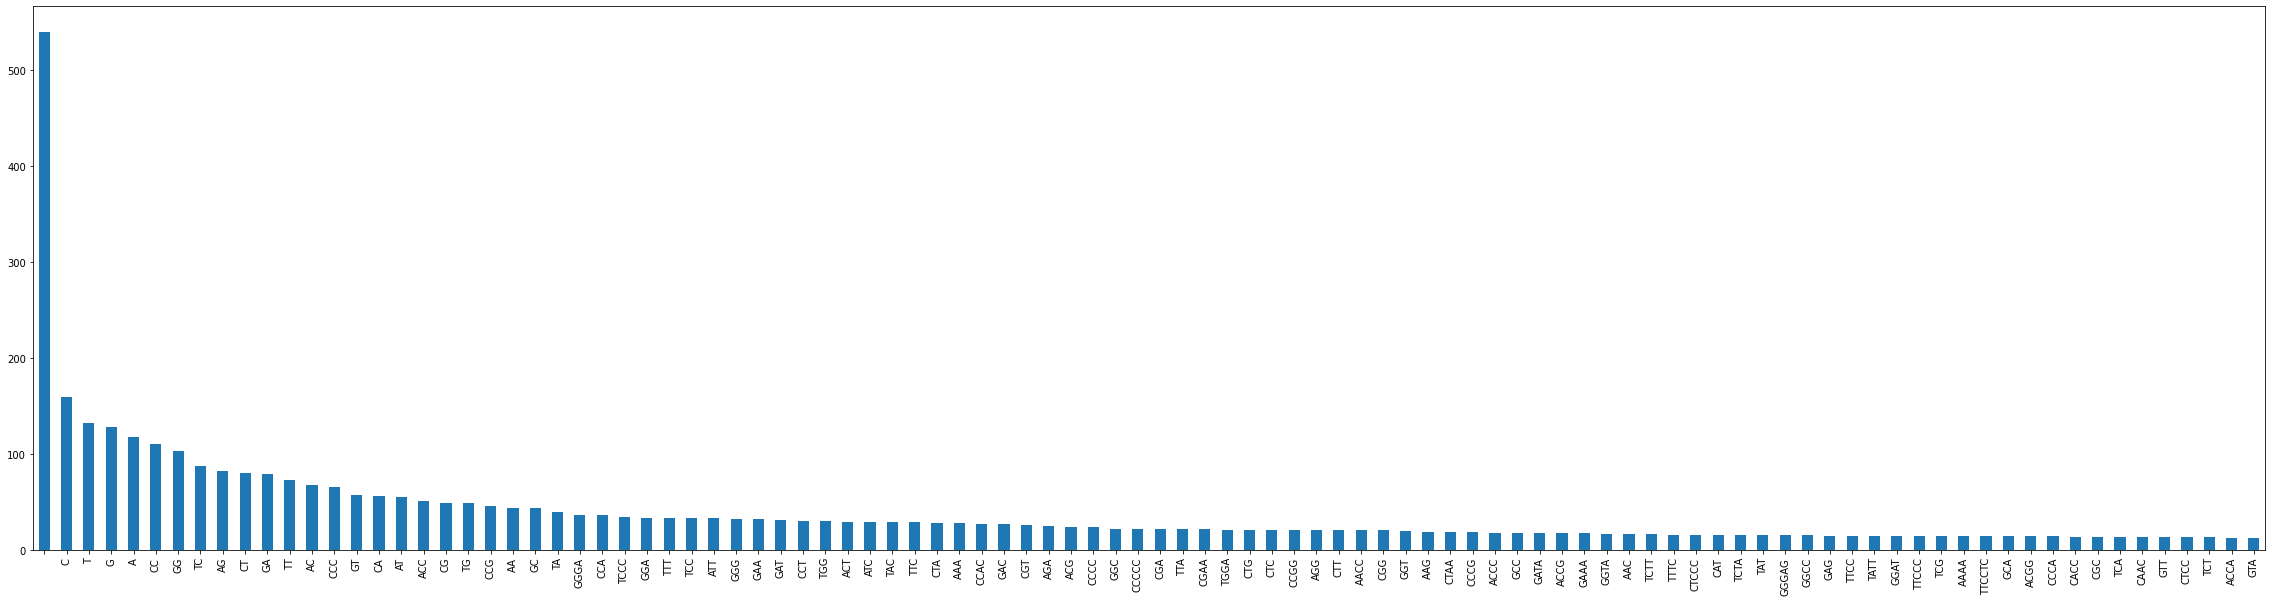

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40,10))
# ax.set_yscale('log')
vd_counts.head(100).plot.bar(ax)